In [1]:

from IPython.display import Image
from matplotlib import pyplot as plt
import pandas as pd, numpy as np
pd.options.display.float_format = '{:,.2f}'.format

from google.cloud import vision
import io

import warnings
warnings.simplefilter("ignore")

import os, cv2
os.chdir(r"D:\AIP11\testfiles")

         
fileList = [x for x in os.listdir() if 'png'  in x.lower()]
fileList[:5]

['Screenshot_20221126_153617.png', 'student1.png', 'teacher1.png']

In [10]:
def segmentation(img):
    img = cv2.imread(img) 
    
    #convert image to greyscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # set threshold to remove background noise
    thresh = cv2.threshold(gray,30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    
    # define rectangle structure (line) to look for: width 100, hight 1. This is a 
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (200,1))
    
    # Find horizontal lines
    lineLocations = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
    
    

    #plt.figure(figsize=(24,24))
    #plt.imshow(lineLocations, cmap='Greys')
    
    df_lineLocations = pd.DataFrame(lineLocations.sum(axis=1)).reset_index()
    df_lineLocations.columns = ['rowLoc', 'LineLength']
    #df_lineLocations[df_lineLocations['LineLength'] > 0]
    
    df_lineLocations['line'] = 0
    df_lineLocations['line'][df_lineLocations['LineLength'] > 100] = 1

    df_lineLocations['cumSum'] = df_lineLocations['line'].cumsum()
    #df_lineLocations.head()
    
    import pandasql as ps

    query = '''
    select row_number() over (order by cumSum) as SegmentOrder
    , min(rowLoc) as SegmentStart
    , max(rowLoc) - min(rowLoc) as Height
    from df_lineLocations
    where line = 0
    --and CumSum !=0
    group by cumSum
    '''

    df_SegmentLocations  = ps.sqldf(query, locals())
    #df_SegmentLocations
    
    
    im2 = img.copy()
    segments = []

    for i in range(len(df_SegmentLocations)):
        y = df_SegmentLocations['SegmentStart'][i]
        h = df_SegmentLocations['Height'][i]

        cropped = im2[y:y + h, 0:lineLocations.shape[1]] 
        segments.append(cropped)
        # plt.figure(figsize=(8,8))
        # plt.imshow(cropped)
        # plt.title(str(i+1))        

    return segments

    

    
    
    
    

OCR TEXT

In [ ]:
import re
import cv2
import pytesseract
from pytesseract import Output

# tell pytesseract where the engine is installed
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files (x86)\Tesseract-OCR\tesseract"


def extractTextFromImg(segment):
    text = pytesseract.image_to_string(segment, lang='eng')         
    text = text.encode("gbk", 'ignore').decode("gbk", "ignore")
        
    return text

#     f=open("file1.txt","w")
#     f.write(text)
#     f.close()
#     g=open("file1.txt","r")
#     a= g.read()
#     print(a)


HANDWRITTEN TExT

In [22]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "D:\AIP11\Tanya-369817-16e0e24e5552.json"
# from google.cloud.vision import types

def CloudVisionTextExtractor(handwritings):
    # convert image from numpy to bytes for submittion to Google Cloud Vision
    _, encoded_image = cv2.imencode('.png', handwritings)
    content = encoded_image.tobytes()
    image = vision.Image(content=content)
    
    # feed handwriting image segment to the Google Cloud Vision API
    client = vision.ImageAnnotatorClient()
    response = client.document_text_detection(image=image)
    
    return response

def getTextFromVisionResponse(response):
    texts = []
    for page in response.full_text_annotation.pages:
        for i, block in enumerate(page.blocks):  
            for paragraph in block.paragraphs:       
                for word in paragraph.words:
                    word_text = ''.join([symbol.text for symbol in word.symbols])
                    texts.append(word_text)

    return ' '.join(texts)

A program counter is a CPU register in the computer processor which has the address of the next instruction to be executed from memory .


An intelligent agent is an entity that uses sensors to understand a situation and make decisions . It can also use actuators to perform both simple and complex tasks . It understands the percepts and acts accordingly .


The Turing test , is a method of testing a machine's human - level intelligence . For example , in a human - versus - machine scenario , a judge will be tasked with identifying which terminal was occupied by a human and which was occupied by a computer based on individual performance . Whenever a computer can pass off as a human , it's deemed intelligent .


TensorFlow is an open - source framework dedicated to ML . It's a combination of libraries , tools , and community resources that help developers build and deploy ML - powered applications .




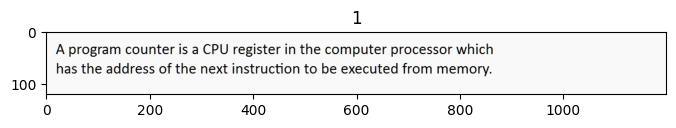

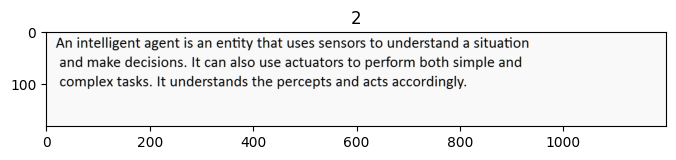

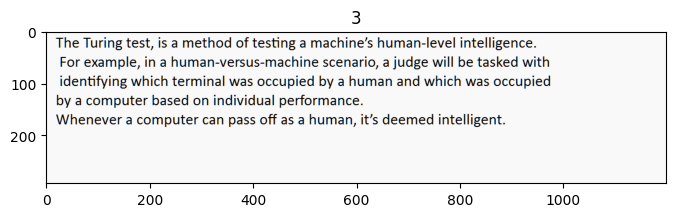

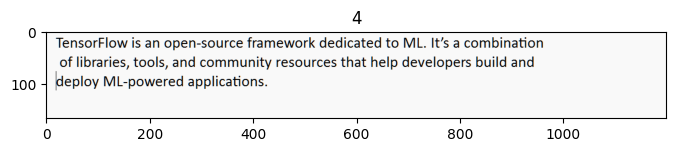

In [27]:
img = fileList[1]
segments = segmentation(img)
for i in segments:
    segment = i
    text = CloudVisionTextExtractor(segment)
    tt = getTextFromVisionResponse(text)
    # type(text)
    print(tt)
    print("\n")